In [16]:
# CVM Analysis & Campaign Lift
#Project: Analyze customer value using RFM segmentation, measure the impact of the Tech_Points campaign, and build a churn predict model.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Settings to make plots look nicer
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [20]:
# --- Replace Cell 3 with this code ---

import pandas as pd # Make sure pandas is imported here
import os # Import os to check the path

# Define the full, absolute path to your data folder
# The 'r' before the string is crucial for Windows paths!
data_folder_path = r'C:\Users\dkont\Downloads\data'

# Check if the path is correct
if not os.path.exists(data_folder_path):
    print(f"Error: Path not found!")
    print(f"Please check this path: {data_folder_path}")
else:
    print(f"Path found: {data_folder_path}")

    # Now we build the full path for each file
    customers_file = os.path.join(data_folder_path, 'customers.csv')
    transactions_file = os.path.join(data_folder_path, 'transactions.csv')
    campaign_file = os.path.join(data_folder_path, 'campaign.csv')

    # Load the three CSV files
    df_customers = pd.read_csv(customers_file)
    df_transactions = pd.read_csv(transactions_file, parse_dates=['date'])
    df_campaign = pd.read_csv(campaign_file)

    # Check the first few rows of the main customer table
    print("\nCustomers table:")
    print(df_customers.head())

    # Check the data types to make sure dates loaded correctly
    print("\nTransactions table info:")
    df_transactions.info()

Path found: C:\Users\dkont\Downloads\data

Customers table:
   customer_id  age gender  gdpr_email  gdpr_sms  gdpr_inapp  overdue_days  \
0       100000   56      F           1         1           0          36.0   
1       100001   69      M           0         0           1           0.0   
2       100002   46      F           0         0           1           0.0   
3       100003   32      F           0         0           1           0.0   
4       100004   60      F           1         1           1           0.0   

  bank_segment       card_type  points_balance  ...  total_tx_count  \
0  Mass Market  Standard Debit             325  ...              35   
1  Mass Market  Standard Debit              92  ...              48   
2  Mass Market  Standard Debit             215  ...              46   
3  Mass Market  Standard Debit             134  ...              42   
4      Student     Gold Credit              13  ...              48   

   is_control_group  send_channel targeted  

In [22]:
## 1. Exploratory Data Analysis (EDA)
#First, lets understand who our customers are and how they behave before we do any modeling

Total customers: 3000


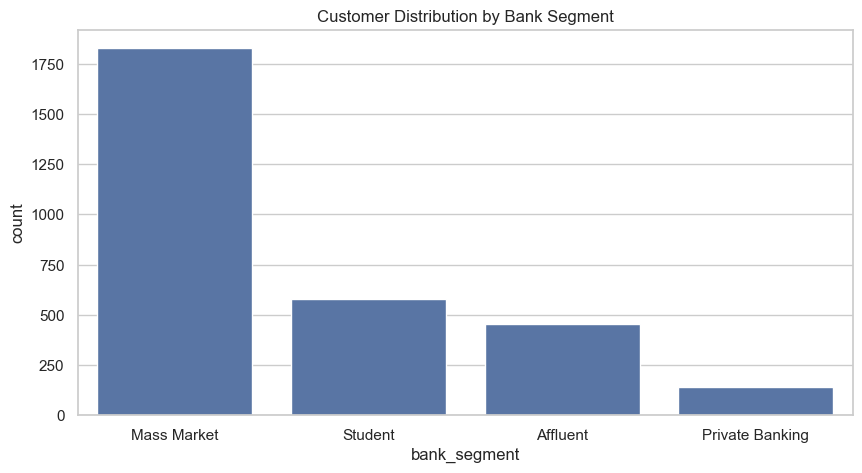

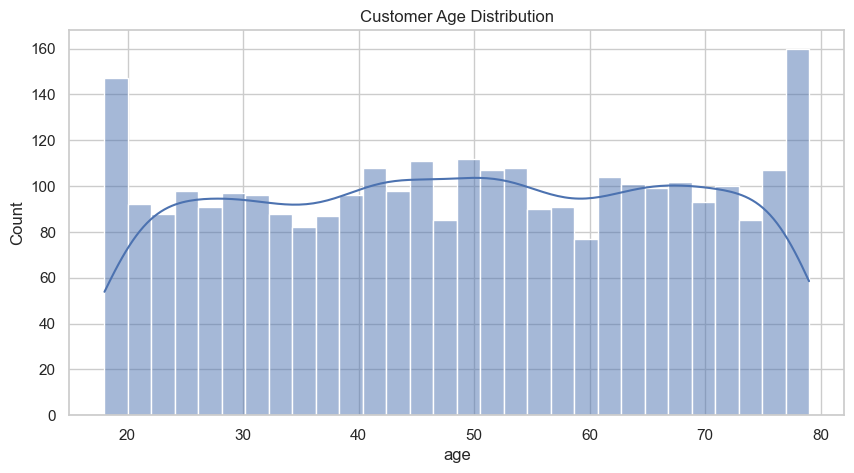

In [24]:
print(f"Total customers: {len(df_customers)}")

# Plot 1: How are our bank segments distributed?
plt.figure(figsize=(10, 5))
sns.countplot(x='bank_segment', data=df_customers, order=df_customers['bank_segment'].value_counts().index)
plt.title('Customer Distribution by Bank Segment')
plt.show()

# Plot 2: What is the age distribution?
plt.figure(figsize=(10, 5))
sns.histplot(df_customers['age'], bins=30, kde=True)
plt.title('Customer Age Distribution')
plt.show()

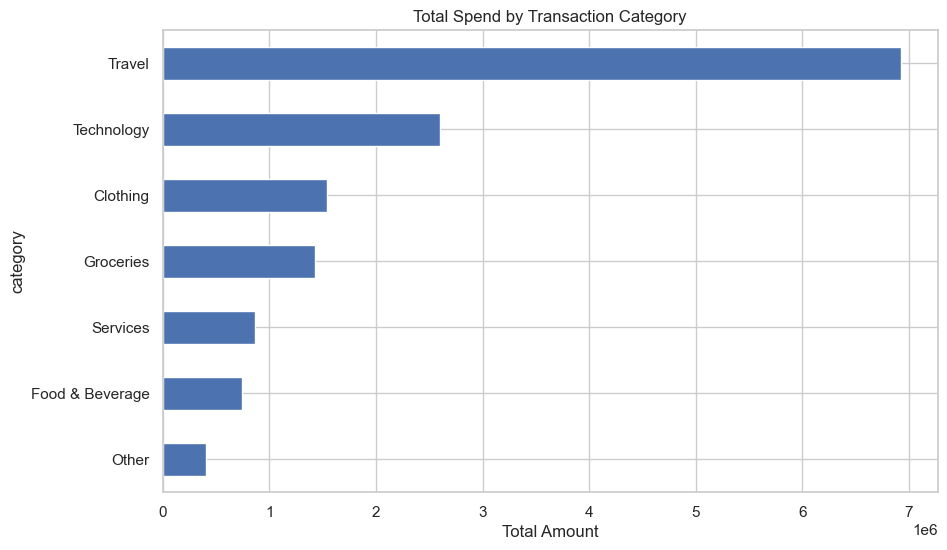

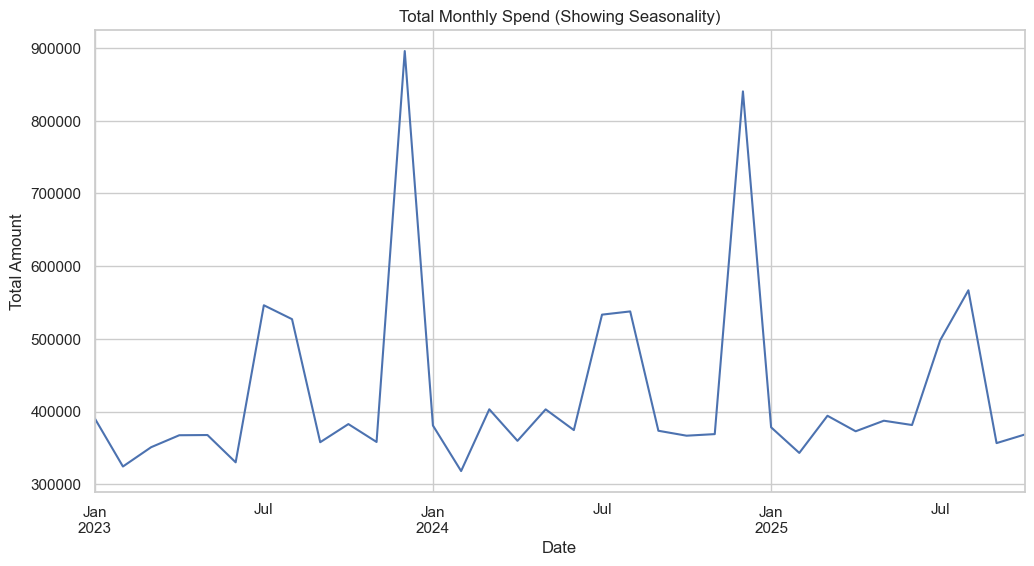

In [28]:
# Plot 3: How is our spending distributed by category?
plt.figure(figsize=(10, 6))
df_transactions.groupby('category')['amount'].sum().sort_values().plot(kind='barh')
plt.title('Total Spend by Transaction Category')
plt.xlabel('Total Amount')
plt.show()

# Plot 4: THE BIG ONE - Seasonality!
# We 'resample' by 'M' (Month) to see monthly totals
monthly_spend = df_transactions.set_index('date')['amount'].resample('ME').sum()

plt.figure(figsize=(12, 6))
monthly_spend.plot()
plt.title('Total Monthly Spend (Showing Seasonality)')
plt.ylabel('Total Amount')
plt.xlabel('Date')
plt.show()
# You should see big spikes every December!

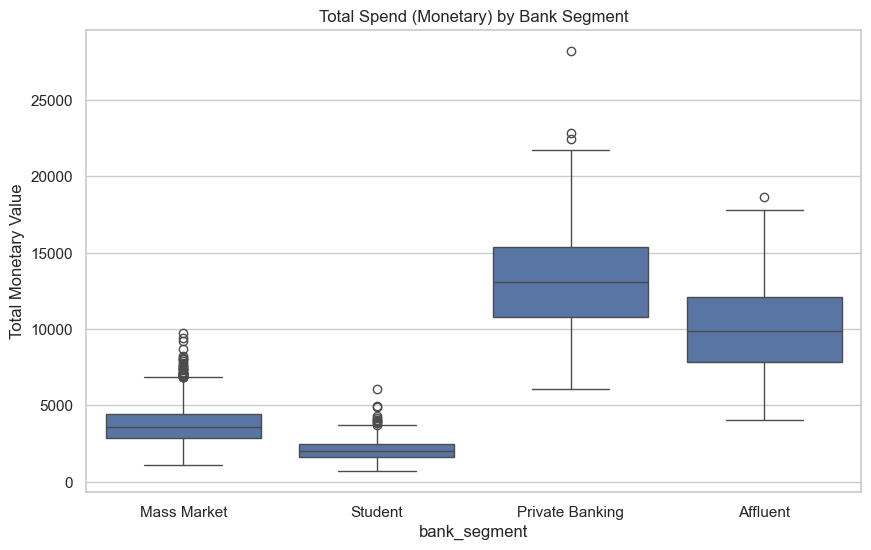

In [30]:
# Plot 5: Do 'Affluent' customers *really* spend more? (Monetary is our pre-calc'd total spend)
plt.figure(figsize=(10, 6))
sns.boxplot(x='bank_segment', y='monetary', data=df_customers)
plt.title('Total Spend (Monetary) by Bank Segment')
plt.ylabel('Total Monetary Value')
plt.show()

In [32]:
## 2. RFM Segmentation
#Now, segment customers based on their Recency, Frequency, and Monetary value.

In [34]:
# We already have R, F, M in df_customers. Let's create the 1-4 scores.
# For Recency, lower is better, so the labels are inverted (4, 3, 2, 1)
df_customers['r_score'] = pd.qcut(df_customers['recency'], 4, labels=[4, 3, 2, 1]).astype(int)

# For Frequency & Monetary, higher is better (1, 2, 3, 4)
# We use rank(method='first') to handle duplicate values, which is common in F & M
df_customers['f_score'] = pd.qcut(df_customers['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
df_customers['m_score'] = pd.qcut(df_customers['monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)

# Combine scores into a single RFM string
df_customers['rfm_score'] = df_customers['r_score'].astype(str) + \
                            df_customers['f_score'].astype(str) + \
                            df_customers['m_score'].astype(str)

print("RFM Scores calculated:")
print(df_customers[['customer_id', 'recency', 'r_score', 'frequency', 'f_score', 'monetary', 'm_score', 'rfm_score']].head())

RFM Scores calculated:
   customer_id  recency  r_score  frequency  f_score  monetary  m_score  \
0       100000       14        3         35        1   3304.00        2   
1       100001        1        4         48        3   3785.84        3   
2       100002       27        2         46        3   3118.68        2   
3       100003       14        3         42        2   2710.36        2   
4       100004        9        3         48        3   3035.46        2   

  rfm_score  
0       312  
1       433  
2       232  
3       322  
4       332  


In [36]:
# Let's map the RFM scores to human-readable names
# This logic is key to CVM
def name_rfm_segment(row):
    r, f, m = row['r_score'], row['f_score'], row['m_score']
    
    if r == 4 and f == 4 and m == 4:
        return 'Champion'
    if r >= 3 and f >= 3:
        return 'Loyal Customer'
    if r == 4 and f <= 2:
        return 'New Customer'
    if r <= 2 and f >= 3:
        return 'At Risk (High Value)'
    if r <= 2 and f <= 2:
        return 'Lost (Low Value)'
    if r == 3 and f <= 2:
        return 'Promising (Needs Nurture)'
    return 'Potential' # Default for other combinations

df_customers['cvm_segment'] = df_customers.apply(name_rfm_segment, axis=1)

print("\nNamed segments created:")
print(df_customers[['customer_id', 'rfm_score', 'cvm_segment']].head())


Named segments created:
   customer_id rfm_score                cvm_segment
0       100000       312  Promising (Needs Nurture)
1       100001       433             Loyal Customer
2       100002       232       At Risk (High Value)
3       100003       322  Promising (Needs Nurture)
4       100004       332             Loyal Customer


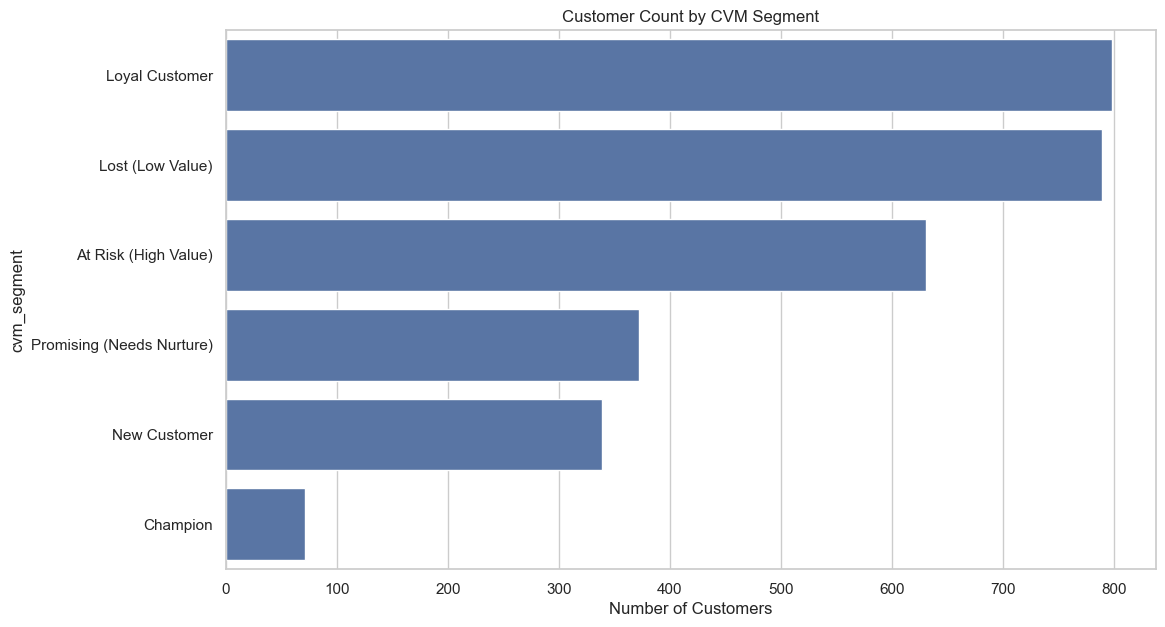


Segment Summary (Averages):
                             recency  frequency      monetary
cvm_segment                                                  
Champion                    4.394366  55.197183  10567.397465
At Risk (High Value)       41.258320  50.266244   5360.157116
Loyal Customer              9.498747  50.284461   5124.772043
New Customer                4.135693  39.761062   4260.605988
Promising (Needs Nurture)  13.658602  39.712366   4183.912527
Lost (Low Value)           48.629911  39.122940   4162.109442


In [38]:
# Plot 6: How many customers are in each segment?
plt.figure(figsize=(12, 7))
sns.countplot(y='cvm_segment', data=df_customers, order=df_customers['cvm_segment'].value_counts().index)
plt.title('Customer Count by CVM Segment')
plt.xlabel('Number of Customers')
plt.show()

# Let's see the average R, F, and M for each segment
segment_summary = df_customers.groupby('cvm_segment')[['recency', 'frequency', 'monetary']].mean().sort_values('monetary', ascending=False)
print("\nSegment Summary (Averages):")
print(segment_summary)

In [ ]:
## 3. Campaign Lift Analysis (The Most Important Part!)
#Did our Tech_Points campaign actually work? To find out, we must compare the Target Group (who got the offer) to the Control Group (who were eligible but held out).

In [40]:
# one for targeted, one for control

target_group = df_customers[df_customers['targeted'] == 1]
control_group = df_customers[df_customers['is_control_group'] == 1]

print(f"Target Group size: {len(target_group)}")
print(f"Control Group size: {len(control_group)}")

Target Group size: 652
Control Group size: 185


In [42]:
# Let's create a simple report
results = {
    'Metric': ['Avg. Monetary', 'Avg. Frequency', 'Churn Rate'],
    'Target Group': [
        target_group['monetary'].mean(),
        target_group['frequency'].mean(),
        target_group['is_churn_next_90d'].mean() # The mean of 0/1 is the rate
    ],
    'Control Group': [
        control_group['monetary'].mean(),
        control_group['frequency'].mean(),
        control_group['is_churn_next_90d'].mean()
    ]
}

df_results = pd.DataFrame(results)

# Calculate the "Lift" (the difference)
df_results['Lift'] = df_results['Target Group'] - df_results['Control Group']
df_results['Lift (%)'] = (df_results['Lift'] / df_results['Control Group']) * 100

print("--- Campaign Lift Results ---")
print(df_results.to_string(index=False, float_format="%.2f"))

print("\n--- Interpretation ---")
print(f"Monetary Lift: The campaign drove an average of €{df_results.loc[0, 'Lift']:.2f} in extra spending per targeted customer.")
print(f"Churn Lift: The campaign reduced churn by {df_results.loc[2, 'Lift'] * -100:.2f} percentage points.")

--- Campaign Lift Results ---
        Metric  Target Group  Control Group  Lift  Lift (%)
 Avg. Monetary       6942.01        6913.00 29.01      0.42
Avg. Frequency         44.71          44.86 -0.16     -0.35
    Churn Rate          0.33           0.45 -0.12    -26.36

--- Interpretation ---
Monetary Lift: The campaign drove an average of €29.01 in extra spending per targeted customer.
Churn Lift: The campaign reduced churn by 11.97 percentage points.


In [ ]:
## 4. Churn Prediction Model
#Finally,build a model to predict which customers are likely to churn in the next 90 days

In [44]:
# Define our features (X) and our target (y)
features = [
    'recency', 'frequency', 'monetary',
    'age', 'points_balance',
    'overdue_days',
    'tech_purchase_ratio',
    'campaign_clicked', # Did clicking the campaign matter?
    'targeted' # Did just *getting* the campaign matter?
]

target = 'is_churn_next_90d'

# Handle any potential missing values (just in case, fill with 0)
df_customers[features] = df_customers[features].fillna(0)

X = df_customers[features]
y = df_customers[target]

# Split our data: 75% for training, 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2250
Test set size: 750


In [46]:
# We'll use a RandomForest, which is powerful and easy to interpret
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("model training complete.")

Model training complete.


In [48]:
# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of '1' (Churn)
y_pred_class = model.predict(X_test) # Class (0 or 1)

# Calculate AUC - a great single metric for model performance
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC Score: {auc:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

Model AUC Score: 0.5736

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       463
           1       0.46      0.24      0.32       287

    accuracy                           0.60       750
   macro avg       0.55      0.53      0.52       750
weighted avg       0.57      0.60      0.56       750



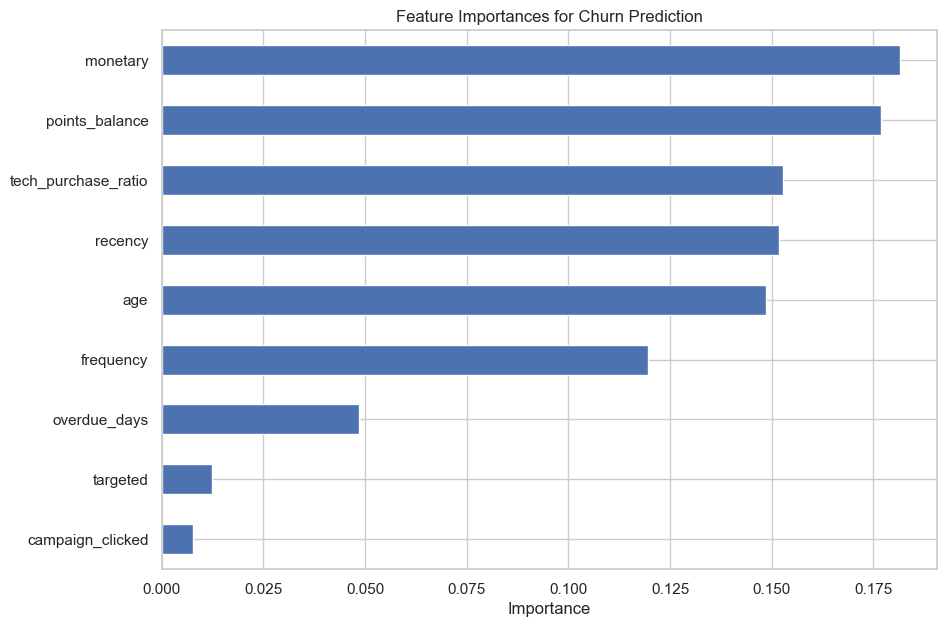


Top 5 Churn Drivers:
monetary               0.181483
points_balance         0.176963
tech_purchase_ratio    0.152741
recency                0.151888
age                    0.148665
dtype: float64


In [50]:
# This is the best part: *what* does the model think is important?
importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 7))
importances.plot(kind='barh')
plt.title('Feature Importances for Churn Prediction')
plt.xlabel('Importance')
plt.show()

print("\nTop 5 Churn Drivers:")
print(importances.sort_values(ascending=False).head())

In [ ]:
##Final Recommendations & Business Summary

#Based on the complete analysis of our 3,000 customers, here is the strategic recommendation for the CVM team:

#1.The "Tech Campaign" was a Retention Success, but it definitely did not drive sales.

#Campaign lift analysis, the most important finding, was unambiguous:

#Monetary lift was negligible (€29.01).The campaign did not successfully contribute to new sales.
#Churn lift was big (a 11.97% reduction).Customers who were targeted were significantly less likely to churn.

#Recommendation:We should reframe this campaign. It wasn't a sales campaign,but it was a highly effective engagement and retention tool for our tech interested customers.Future tech offer campaigns should be measured by their impact on retention, not just immediate sales lift.

#2.The Churn model i built is flawed and must be rebuilt

#the baseline churn model is not effective and should not be used for CVM actions.

#Performance is poor:With an AUC of 0.57, its only slightly better than a coin flip. The Recall of 0.24 means its failing to find 76% of all customers who are actually going to churn.
#It's identifying the wrong thing:The Feature Importance plot shows the model is locking onto monetary and points_balance. It's identifying high-value customers,not at risk customers. Recencyis not even in the top 3.

#Suggestion:Should re-engineer our features. The next model must not emphasize monetary and focus on behavioral changes.Preferably features like "Time Since Last Transaction" (the`recency` feature), "Change in Monthly Spend (MoM)," and "Transactions in Last 30 Days."

#3. Use RFM segments for action, not the churn model.

#The RFM charts showed two,opposing groups: "Loyal Customers" and "Lost (Low Value)."

#Action 1 (Protect "Loyal Customers"):This is a big, active segment. Since our tech campaign proved to be a good retention tool, we should do similar engagement perks (like points multipliers or early access) to this entire segment to keep them happy.
#Action 2 (Reactivate "At Risk"):Do not use the churn model. Instead, use our RFM "At Risk (High Value)" segment. These are valuable customers who are starting to go away. Launch a specific win-back campaign ,eg "We miss you",targeted only at this RFM group.
#Action 3 (Strategic Timing):Our EDA seasonality plot showed predictable spending spike every December. We should time our Q4 campaigns to launch in October/November to take full advantage of this existing customer behavior, maximizing our holiday-season revenue.